In [27]:
import numpy as np

class PCA:
    """
    Principal Component Analysis (PCA)
    """
    
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ratio_ = None
    
    def fit(self, X):
        """
        Fit the PCA model to the data.
        
        Args:
        X: numpy array of shape (n_samples, n_features)
        """
        # Subtract the mean of each feature
        self.mean_ = np.mean(X, axis=0)
        X = X - self.mean_
        
        # Calculate the covariance matrix
        cov = np.cov(X, rowvar=False)
        
        # Calculate the top n_components eigenvectors using the power iteration method
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        sort_indices = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:,sort_indices]
        if self.n_components is not None:
            self.components_ = eigenvectors[:,:self.n_components]
            self.explained_variance_ratio_ = eigenvalues[sort_indices][:self.n_components] / np.sum(eigenvalues)
        else:
            self.components_ = eigenvectors
            self.explained_variance_ratio_ = eigenvalues[sort_indices] / np.sum(eigenvalues)
    
    def transform(self, X):
        """
        Transform the data using the fitted PCA model.
        
        Args:
        X: numpy array of shape (n_samples, n_features)
        
        Returns:
        X_pca: numpy array of shape (n_samples, n_components)
        """
        # Subtract the mean of each feature
        X = X - self.mean_
        
        # Project the data onto the top n_components eigenvectors
        if self.n_components is not None:
            components = self.components_
        else:
            components = np.identity(X.shape[1])
        X_pca = np.dot(X, components)
        
        return X_pca

In [28]:
import pickle

# Load the list from the file using pickle
with open("dataset.pkl", "rb") as f:
    my_list = pickle.load(f)


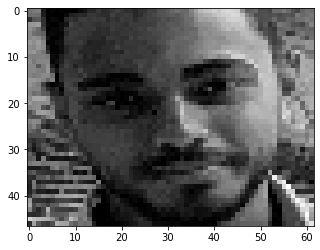

In [29]:
import matplotlib.pyplot as plt
import cv2

# Get a random image from the dataset
sample_image = my_list[0][18]
sample_image = sample_image.reshape(47,62)
# Display the image

plt.imshow(sample_image, cmap='gray')
plt.show()

In [30]:
X , y , names = my_list

In [31]:
import numpy as np

In [32]:
X = np.array(X)

In [33]:
print(X.shape)

(218, 2914)


In [34]:
import numpy as np
from sklearn import  metrics
from sklearn.model_selection import train_test_split
from sklearn import svm

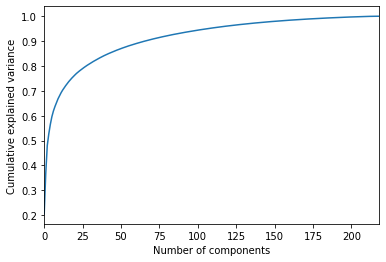

In [35]:
# create a PCA object with all components
pca = PCA()

# fit the data to the PCA object
pca.fit(X)

# plot the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim((0,X.shape[0]))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [36]:
# Apply PCA to the raw pixel values
n_components = 170
pca = PCA(n_components=n_components)
eigenfaces = pca.fit(X)
eigenfaces = pca.transform(X)


In [37]:
eigenfaces.shape

(218, 170)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(eigenfaces, y, test_size=0.1,random_state=42)


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Assuming X_train and y_train are your training data and target variable
# Define the parameter grid for the SVM classifier
parameters = {'kernel' : ('poly', 'rbf','linear'), 'C':[0.01, 0.1, 0.5, 1, 10]}


# Create the SVM classifier with an RBF kernel
clf = SVC(kernel='rbf')

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf, parameters, cv=10)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best value of C found by GridSearchCV
print("Best kernel :", grid_search.best_params_['kernel'])
print("Best C value found:", grid_search.best_params_['C'])

Best kernel : linear
Best C value found: 0.01


In [40]:
# Train an SVM model using the training set
clf = SVC(kernel='linear', C=0.01, probability=True)
# clf = svm.LinearSVC(C=0.01)
clf.fit(X_train, y_train)


SVC(C=0.01, kernel='linear', probability=True)

In [41]:
y_pred = clf.predict(X_test)


In [42]:
# Evaluate the performance of the model
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")

Accuracy: 0.9090909090909091
Precision: 0.922077922077922
Recall: 0.9090909090909091
F1 score: 0.8898601398601399


In [54]:
import cv2

def predict_image(path,model,pca,names):
    # Load the pre-trained face detection classifier
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Set the new width and height
    # new_width = 500
    # new_height = 500

    img = cv2.imread(path)

    # Resize the image
    # resized_img = cv2.resize(img, (new_width, new_height))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5)
    max = 0
    for i in range(len(faces)):
        if faces[i][2] * faces[i][3] > max:
            max = faces[i][2] * faces[i][3]
            real_face = faces[i]

    x, y, w, h =  real_face
    cropped_img = gray[y:y+h, x:x+w]

    cropped_img = cv2.resize(cropped_img,(62, 47))
    flatten_img = cropped_img.flatten().reshape(1,-1)
    flatten_img = pca.transform(flatten_img)
    result = model.predict(flatten_img)
    confidence = model.decision_function(flatten_img)
    prob =clf.predict_proba(flatten_img)

    # Print the prediction and confidence
    print("Prediction:", names[int(result)])
    print("Confidence:", confidence)
    print("prob:", prob)

In [80]:
predict_image('C:/Users/A/Desktop/FB_IMG_1532900589089.jpg',clf,pca,names)

Prediction: Mina
Confidence: [[ 4.2  -0.27  3.24  2.26  0.74]]
prob: [[0.41 0.01 0.35 0.18 0.04]]


In [45]:
with open('last_model.pkl', 'wb') as f:
    pickle.dump((pca, clf,names), f)

In [46]:
import pickle

# Load the saved model from the file
with open('last_model.pkl', 'rb') as f:
    pca, clf ,names= pickle.load(f)


Confusion matrix, without normalization
[[4 0 0 0 0]
 [0 1 0 1 1]
 [0 0 3 0 0]
 [0 0 0 6 0]
 [0 0 0 0 6]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.  ]
 [0.   0.33 0.   0.33 0.33]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]


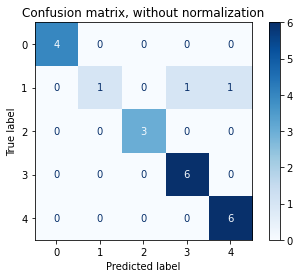

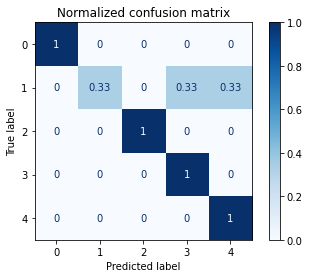

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        # display_labels=names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [49]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(22, 5)

In [50]:
label_binarizer.transform([4])

array([[0, 0, 0, 0, 1]])

In [51]:
class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score=clf.predict_proba(X_test)


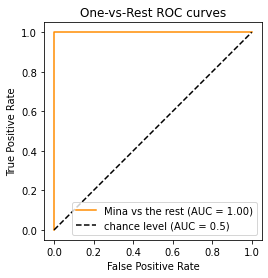

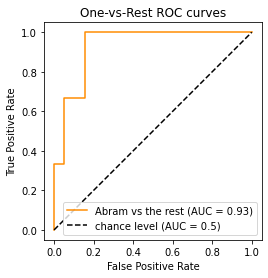

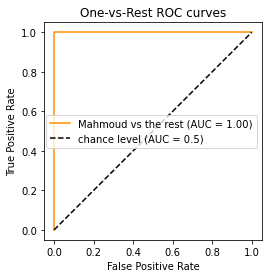

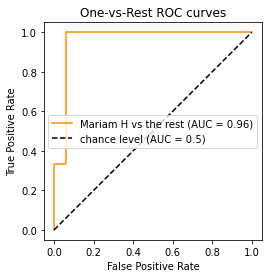

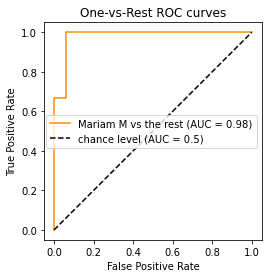

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
names=['Mina','Abram','Mahmoud','Mariam H','Mariam M']
for i in range(0,5):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{names[i]} vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves")
    plt.legend()
    plt.savefig(f'ROC_{names[i]}.png')
    plt.show()
    

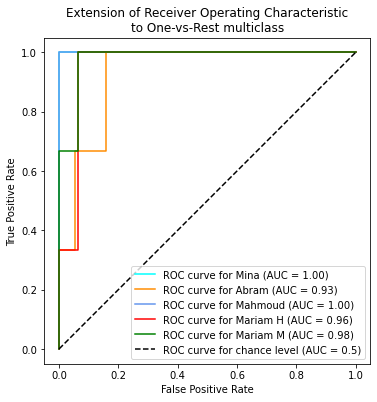

In [82]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


colors = cycle(["aqua", "darkorange", "cornflowerblue",'red','green'])
for class_id, color in zip(range(5), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.savefig('ROC_all.png')
plt.show()